In [2]:
import os
import numpy as np
import pandas as pd
import time, datetime

import matplotlib.pyplot as plt

%matplotlib inline


# from sklearn.cluster import KMeans
# from sklearn.cluster import AffinityPropagation
# from sklearn.cluster import AgglomerativeClustering
# from sklearn.cluster import MeanShift





In [3]:
curr_wd = os.getcwd()
data_dir = os.path.join(curr_wd, 'Data')
data_dir

'/Users/derekwang/Work/Forecasting/Final_Forecast_Process_0108/Data'

In [8]:
factors_df_dir = os.path.join(data_dir, 'Output/sample_Seasonalities_0109.csv')
factors_df = pd.read_csv(factors_df_dir, sep = ',', header=0, index_col=0)
print (np.size(factors_df, 0))
factors_df.head()

10


,SKU,Store,Class_label,1,2,3,4,5,6,7,...,43,44,45,46,47,48,49,50,51,52
0,999,102,2.0,0.837626,0.927434,0.882848,0.925839,0.923984,0.944014,0.976596,...,0.925497,0.935241,0.879491,0.833075,0.779141,0.754883,0.809062,0.974490,0.993335,1.009211
1,999,103,0.0,1.001545,1.008057,0.957280,0.925168,0.975045,1.036203,1.066123,...,0.884999,0.866189,0.866126,0.849489,0.779881,0.770145,0.791896,0.818342,0.840581,0.868114
2,999,104,3.0,0.947847,0.900682,0.871764,0.873353,0.893586,0.960939,1.004158,...,0.962132,0.921926,0.901272,0.869915,0.768119,0.712503,0.773084,0.804383,0.843947,0.830326
3,999,105,2.0,0.837626,0.927434,0.882848,0.925839,0.923984,0.944014,0.976596,...,0.925497,0.935241,0.879491,0.833075,0.779141,0.754883,0.809062,0.974490,0.993335,1.009211
4,999,106,0.0,1.001545,1.008057,0.957280,0.925168,0.975045,1.036203,1.066123,...,0.884999,0.866189,0.866126,0.849489,0.779881,0.770145,0.791896,0.818342,0.840581,0.868114


In [41]:
#Fake an ARIMA output
demand_raw_dir = os.path.join(data_dir, 'SAMPLE3YearSales.txt')
demand_raw_df = pd.read_csv(demand_raw_dir, sep = '\t', header=0)
fake_ARIMA = demand_raw_df.loc[:,['SKU', 'Store', 'Week', 'Units']][demand_raw_df.Week>201552]
fake_ARIMA.to_csv(os.path.join(data_dir, 'fake_ARIMA_0109.txt'))
fake_ARIMA.head()

,SKU,Store,Week,Units
1040,999,108,201601,193.000
1041,999,110,201601,117.000
1042,999,102,201601,112.000
1043,999,107,201601,148.456
1044,999,104,201601,186.000


In [40]:
ARIMA_dir = os.path.join(data_dir, 'fake_ARIMA_0109.txt')
ARIMA_df_raw = pd.read_csv(ARIMA_dir, sep = ',', header = 0, index_col=0).sort_values(by=['SKU', 'Store', 'Week'])
ARIMA_df_raw.reset_index(drop=True)
STR_SKU_LIST = ARIMA_df_raw.loc[:, ['SKU', 'Store']].drop_duplicates().copy().reset_index(drop=True)

ARIMA_output = ARIMA_df_raw['Units'].values.reshape(-1,52)
ARIMA_h = pd.DataFrame(ARIMA_output, columns = [i for i in range(1,53)])
ARIMA_df = pd.concat([STR_SKU_LIST, ARIMA_h], axis=1)
ARIMA_df.head()


,SKU,Store,1,2,3,4,5,6,7,8,...,43,44,45,46,47,48,49,50,51,52
0,999,102,112.0,103.0,73.0,114.0,67.0,124.0,100.0,112.0,...,74.0,87.0,88.0,58.0,81.0,65.0,126.0,169.0,146.0,95.0
1,999,103,63.0,83.0,57.0,76.0,140.0,76.0,120.0,82.0,...,106.0,70.0,81.0,79.0,62.0,49.0,97.0,85.0,74.0,59.0
2,999,104,186.0,117.0,152.0,139.0,145.0,171.0,183.0,169.0,...,156.0,151.0,111.0,117.0,134.0,98.0,156.0,138.0,143.0,141.0
3,999,105,61.0,64.0,77.0,81.0,98.0,97.0,103.0,105.0,...,79.0,83.0,64.0,53.0,78.0,45.0,46.0,121.0,70.0,69.0
4,999,106,131.0,212.0,143.0,136.0,162.0,213.0,159.0,143.0,...,111.0,120.0,146.0,129.0,103.0,99.0,128.0,107.0,125.0,129.0


In [27]:
def get_Kmeans_fcst(base_df, factors_df):
    merge = pd.merge(base_df, factors_df.drop(['Class_label'], axis=1), how='inner', on=['SKU', 'Store'])
    matrix_base = merge.iloc[:,2:54].values
    matrix_factors = merge.iloc[:,54:106].values
    matrix_fcst = matrix_base*matrix_factors
    fcst_df = pd.DataFrame(matrix_fcst, columns=['Week%d' % i for i in range(1,53)])
    result = pd.concat([merge.loc[:,['SKU','Store']], fcst_df], axis =1)
    return result


def cal_ABS_error(df_fcst, df_actual, num_of_weeks):
    
    df_compare = pd.merge(df_fcst, df_actual, how = 'left', on = ['ITEM_ID', 'LOC_ID'])
    fcst_matrix = df_compare.iloc[:,2:2+num_of_weeks].values
    act_matrix = df_compare.iloc[:,2+num_of_weeks:2+num_of_weeks+num_of_weeks].values
    ABS_error = np.nansum(abs(fcst_matrix - act_matrix))
    
    return ABS_error
    
def cal_Bias_error(df_fcst, df_actual, num_of_weeks):
    
    df_compare = pd.merge(df_fcst, df_actual, how = 'left', on = ['ITEM_ID', 'LOC_ID'])
    fcst_matrix = df_compare.iloc[:,2:2+num_of_weeks].values
    act_matrix = df_compare.iloc[:,2+num_of_weeks:2+num_of_weeks+num_of_weeks].values
    Bias_error = np.nansum(fcst_matrix - act_matrix)
    
    return Bias_error

def cal_Square_error(df_fcst, df_actual, num_of_weeks):
    
    df_compare = pd.merge(df_fcst, df_actual, how = 'left', on = ['ITEM_ID', 'LOC_ID'])
    fcst_matrix = df_compare.iloc[:,2:2+num_of_weeks].values
    act_matrix = df_compare.iloc[:,2+num_of_weeks:2+num_of_weeks+num_of_weeks].values
    Square_error = np.nansum(np.square(fcst_matrix - act_matrix))
    
    return Square_error

def cal_PCT_error(df_fcst, df_actual, num_of_weeks):
    
    df_compare = pd.merge(df_fcst, df_actual, how = 'left', on = ['ITEM_ID', 'LOC_ID'])
    fcst_matrix = df_compare.iloc[:,2:2+num_of_weeks].values
    act_matrix = df_compare.iloc[:,2+num_of_weeks:2+num_of_weeks+num_of_weeks].values
    PCT_error = np.nansum(abs(fcst_matrix - act_matrix)/act_matrix)
    
    return PCT_error

def cal_errors(df_fcst, df_actual, num_of_weeks):
    
    df_compare = pd.merge(df_fcst, df_actual, how = 'inner', on = ['ITEM_ID', 'LOC_ID'])
    fcst_matrix = df_compare.iloc[:,2:2+num_of_weeks].values
    act_matrix = df_compare.iloc[:,2+num_of_weeks:2+num_of_weeks+num_of_weeks].values
    ABS_error = np.nansum(abs(fcst_matrix - act_matrix))
    Bias_error = np.nansum(fcst_matrix - act_matrix)
    Square_error = np.nansum(np.square(fcst_matrix - act_matrix))
    
    print ('ABS_error is: %d' % ABS_error)
    print ('Bias_error is: %d' % Bias_error)
    print ('Square_error is: %d' % Square_error)
    
    print ('Number of STR_SKU is: %d' % np.size(df_compare, 0))
    
    return ABS_error, Bias_error, Square_error


def Kmeans_eval(kmean_fcst, DCM_fcst, act_demand, df_result):
    
    merge1 = pd.merge(kmean_fcst, DCM_fcst, how = 'inner', on = ['ITEM_ID', 'LOC_ID'])
    merge2 = pd.merge(merge1, act_demand, how = 'inner', on = ['ITEM_ID', 'LOC_ID'])
    merge3 = pd.merge(merge2, df_result, how = 'left', on = ['ITEM_ID', 'LOC_ID'])
    
    kmean_matrix = merge2.iloc[:,2:20].values
    dcm_matrix = merge2.iloc[:,20:38].values
    act_matrix = merge2.iloc[:,38:56].values
    
    kmeans_error = np.nansum(abs(kmean_matrix - act_matrix), axis = 1)
    DCM_error = np.nansum(abs(dcm_matrix - act_matrix), axis = 1)
    
    result_df = merge3.loc[:,['ITEM_ID', 'LOC_ID']].copy()
    result_df['GROUP_ID'] = merge3['GROUP_ID']
    result_df['Class_label'] = merge3['Class_label']
    result_df['Kmeans_error'] = kmeans_error
    result_df['DCM_error'] = DCM_error
    result_df['Kmeans_better'] = np.where(result_df['Kmeans_error'] < result_df['DCM_error'], 1, 0)
    
    
    
    return result_df


def std_eval(kmean_fcst, DCM_fcst, act_demand, mean_base_demand, df_result):
    
    merge1 = pd.merge(kmean_fcst, DCM_fcst, how = 'inner', on = ['ITEM_ID', 'LOC_ID'])
    merge2 = pd.merge(merge1, act_demand, how = 'inner', on = ['ITEM_ID', 'LOC_ID'])
    merge3 = pd.merge(merge2, mean_base_demand, how = 'inner', on = ['ITEM_ID', 'LOC_ID'])
    merge4 = pd.merge(merge3, df_result, how = 'left', on = ['ITEM_ID', 'LOC_ID'])
    
    kmean_matrix = merge3.iloc[:,2:20].values
    dcm_matrix = merge3.iloc[:,20:38].values
    act_matrix = merge3.iloc[:,38:56].values
    
    mean_matrix = merge3.iloc[:,56:108].mean(axis = 1).values
    
#     kmeans_error = np.std((kmean_matrix - act_matrix), axis = 1) / mean_matrix
#     DCM_error = np.std((dcm_matrix - act_matrix), axis = 1) / mean_matrix
    
    kmeans_error = np.std((kmean_matrix - act_matrix), axis = 1) 
    DCM_error = np.std((dcm_matrix - act_matrix), axis = 1) 
    
    result_df = merge4.loc[:,['ITEM_ID', 'LOC_ID']].copy()
#     result_df['GROUP_ID'] = merge4['GROUP_ID']
    result_df['Class_label'] = merge4['Class_label']
    result_df['Kmeans_Bias_std_pct'] = kmeans_error
    result_df['DCM_Bias_std_pct'] = DCM_error
    result_df['Kmeans_better'] = np.where(result_df['Kmeans_Bias_std_pct'] < result_df['DCM_Bias_std_pct'], 1, 0)
    
    
    
    return result_df

In [43]:
kmean_fcst = get_Kmeans_fcst(ARIMA_df, factors_df)
# kmean_fcst.to_csv(os.path.join(data_dir, 'Output/final_forecast_0109.csv'))
kmean_fcst

,SKU,Store,Week1,Week2,Week3,Week4,Week5,Week6,Week7,Week8,...,Week43,Week44,Week45,Week46,Week47,Week48,Week49,Week50,Week51,Week52
0,999,102,93.814118,95.525731,64.447877,105.545608,61.906908,117.057789,97.659572,109.484035,...,68.486788,81.365963,77.395242,48.318378,63.110445,49.067395,101.941791,164.688773,145.026849,95.875026
1,999,103,63.097325,83.668731,54.564938,70.312777,136.506257,78.751406,127.934735,87.177416,...,93.809900,60.633207,70.156215,67.109594,48.352626,37.737093,76.813909,69.559050,62.202973,51.218723
2,999,104,176.299546,105.379811,132.508107,121.396121,129.570008,164.320492,183.760953,175.793440,...,150.092540,139.210841,100.041197,101.780045,102.927964,69.825258,120.601113,111.004801,120.684443,117.075903
3,999,105,51.095189,59.355794,67.979267,74.992932,90.550403,91.569400,100.589359,102.641283,...,73.114274,77.624999,56.287449,44.153001,60.773021,33.969735,37.216844,117.913264,69.533421,69.635545
4,999,106,131.202375,213.708084,136.890986,125.822865,157.957240,220.711176,169.513524,152.028908,...,98.234895,103.942641,126.454411,109.584021,80.327749,76.244332,101.362684,87.562569,105.072590,111.986699
5,999,107,148.685341,196.571115,181.883128,128.598369,152.106972,157.502811,158.852296,170.102274,...,138.944852,123.864980,134.249546,80.701411,75.648463,82.405490,53.057030,97.382671,84.058072,78.998369
6,999,108,161.661828,225.366531,146.552706,149.060026,167.241050,177.474713,177.740420,158.360836,...,173.993461,180.501504,122.249303,138.290530,105.184074,95.115258,132.686141,168.586732,154.960195,163.492150
7,999,109,102.157574,126.007125,130.190029,89.741308,135.531212,196.878514,202.563331,217.943539,...,106.199887,109.139773,98.738376,88.346808,65.510009,89.336792,63.351677,94.927645,110.956655,110.250471
8,999,110,92.855152,89.380482,135.862635,98.943180,178.904146,144.929061,154.788794,127.948635,...,111.687507,193.358560,90.323259,103.472040,63.703179,76.417949,130.414944,146.956963,146.749913,141.780422
9,999,111,250.231614,233.276675,234.504478,241.918888,263.607946,319.992536,293.214198,274.612238,...,289.601632,210.199151,226.219283,242.706260,132.116491,116.137930,146.112887,242.923550,205.923106,172.707715


In [7]:
act_DMND_dir = os.path.join(data_dir, 'EndtoEnd_act_DMND_ITEM_LOC_1205.csv')
act_DMND_df = pd.read_csv(act_DMND_dir, sep = ',', header=0)
print (np.size(act_DMND_df, 0))
act_DMND_df.head()

498271


,ITEM_ID,LOC_ID,DMND26,DMND27,DMND28,DMND29,DMND30,DMND31,DMND32,DMND33,DMND34,DMND35,DMND36,DMND37,DMND38,DMND39,DMND40,DMND41,DMND42,DMND43
0,2840071,2449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
1,2840101,2449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2,2840144,2449,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
3,2585947,1382,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.000,1.0,0.0,2.0,0.0,3.0
4,2585947,2255,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.163,0.0,0.0,0.0,0.0,0.0


In [28]:
#calculate DCM_fcst_error
target_DCM_FCST = pd.merge(fcst_result.iloc[:,0:2], DCM_FCST_df, how = 'inner', on = ['ITEM_ID', 'LOC_ID'] )
cal_errors(target_DCM_FCST, act_DMND_df, 18)

ABS_error is: 9206233
Bias_error is: 277590
Square_error is: 211499567
Number of STR_SKU is: 321151


(9206233.7639999948, 277590.1579999997, 211499567.34793004)

In [29]:
#calculate Kmeans_fcst_error
target_kmeans_FCST = pd.merge(target_DCM_FCST.iloc[:,0:2], fcst_result, how = 'inner', on = ['ITEM_ID', 'LOC_ID'] )
kmeans_error = cal_errors(target_kmeans_FCST, act_DMND_df, 18)
kmeans_error

ABS_error is: 9217507
Bias_error is: -252628
Square_error is: 212154531
Number of STR_SKU is: 321151


(9217507.7657089457, -252628.37544848651, 212154531.42620853)

In [30]:
performance = std_eval(fcst_result, DCM_FCST_df, act_DMND_df, mean_base_demand, df_result)
performance.describe()

,Class_label,Kmeans_Bias_std_pct,DCM_Bias_std_pct,Kmeans_better
count,321151.000000,321151.000000,321151.000000,321151.00000
mean,5663.305931,1.883953,1.902515,0.50068
std,4951.482593,5.132104,5.195172,0.50000
min,0.000000,0.000000,0.000000,0.00000
25%,12.000000,0.623811,0.634886,0.00000
50%,9999.000000,1.025592,1.033886,1.00000
75%,9999.000000,1.725130,1.743734,1.00000
max,9999.000000,650.740635,652.735212,1.00000


In [32]:
summary = performance.groupby(['Class_label']).mean()
summary_count = performance.groupby(['Class_label']).size()
summary['COUNT'] = summary_count
summary
# summary.to_csv(os.path.join(data_dir, 'summary_1213.csv'))

,Kmeans_Bias_std_pct,DCM_Bias_std_pct,Kmeans_better,COUNT
Class_label,,,,
0,2.394302,2.378244,0.448361,3631
1,3.646900,3.706347,0.525129,18226
2,2.741183,2.775012,0.493934,7995
3,3.099201,3.156691,0.524997,7581
4,4.653483,4.658867,0.453316,1553
5,2.933967,2.933921,0.448244,8685
6,3.551388,3.587333,0.528690,16626
7,4.930804,4.881168,0.413483,445
8,3.796320,3.825155,0.536541,6527


In [46]:
# performance[(performance['Class_label'] == 15)]
performance[(performance['ITEM_ID'] == 170240) & (performance['LOC_ID'] == 1769)]

,ITEM_ID,LOC_ID,Class_label,Kmeans_Bias_std_pct,DCM_Bias_std_pct,Kmeans_better
34855,170240,1769,15,3.621067,3.407189,0


In [34]:
#Function to plot seasonality curves 
def plot_class_curve(df):
    class_data = df.groupby(['Class_label']).mean()
    
    num = np.size(class_data, 0)
    
    if num == 1:
        plt.plot(class_data.iloc[0, 0:52].values)
        plt.title('Class 0')
    
    else:
        #yticks = np.arange(0, 1.1, 0.1)
        row = int(np.ceil(num/2))
        f, axarr = plt.subplots(row, 2)
        for i in range(num):
            column = int(np.floor(i / row))
            no = i % row
            axarr[no, column].plot(class_data.iloc[i, 0:52].values)
            axarr[no, column].set_title('Class %s' % i)
            #axarr[no, column].set_yticks(yticks)
        
        
    
        #xticks = np.arange(0, 52, 10)
        
        #labels = np.arange(1, 53, 1)
        #plt.xticks(xticks, labels)
        #plt.yticks(yticks)
        #plt.title('Class %s' % i)
    
    plt.show()

    
#Function to plot forecast vs. actual demand
def plot_fcst_compare(ITEM_ID, LOC_ID):
    fcst = fcst_result[(fcst_result['ITEM_ID'] == ITEM_ID) & (fcst_result['LOC_ID'] == LOC_ID)].iloc[0,2:].values
    dcm = DCM_FCST_df[(DCM_FCST_df['ITEM_ID'] == ITEM_ID) & (DCM_FCST_df['LOC_ID'] == LOC_ID)].iloc[0,2:].values
    act = act_DMND_df[(act_DMND_df['ITEM_ID'] == ITEM_ID) & (act_DMND_df['LOC_ID'] == LOC_ID)].iloc[0,2:].values
    
   
    xticks = np.arange(26, 44)
    
    data = pd.DataFrame({'Kmeans': fcst,
                         'DCM': dcm,
                         'act': act}, index= xticks)
    
    plt.plot(xticks, fcst, label = 'Kmeans_fcst')
    plt.plot(xticks, dcm, label = 'DCM_fcst')
    plt.plot(xticks, act, label = 'ACT_DMND')
    plt.legend()
    plt.title('Forecast Comparison for ITEM_ID = %s LOC_ID = %s' % (ITEM_ID, LOC_ID) )
    plt.xticks(xticks)
    
    plt.show()
    return data

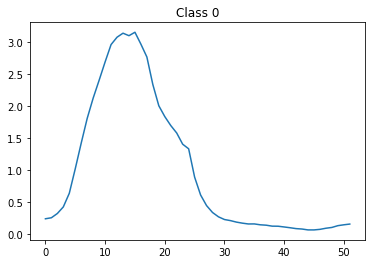

In [39]:
#plot target seasonality profile for a group 

group_id = 7

plot_group = df_result[(df_result['Class_label'] == group_id)]
plot_class_curve(plot_group)

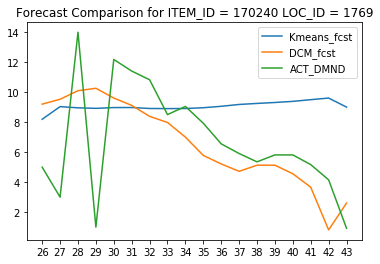

,DCM,Kmeans,act
26,9.203,8.19572,5.000
27,9.529,9.03782,3.000
28,10.099,8.95881,14.000
29,10.262,8.92233,1.000
30,9.611,8.97534,12.184
31,9.122,8.97899,11.411
32,8.389,8.91456,10.830
33,7.982,8.9061,8.507
34,7.004,8.91241,9.051
35,5.783,8.96508,7.930


In [48]:
plot_fcst_compare(170240, 1769)

In [39]:
#try to find best k for K-means alg
k_means_error = []
option_k = [1, 5, 10, 50, 100, 150, 200]



for k in option_k:
    
    print (str(datetime.datetime.now()))
    X_train = data_ncq.iloc[:,2:54].values
    kmeans = KMeans(n_clusters = k, random_state=0).fit(X_train)
    out_labels = kmeans.labels_


    pieces = []

    #get the result from Kmeans
    df_km_result = data_scal.copy()
    df_km_result['Class_label'] = out_labels.astype('int')
    pieces.append(df_km_result)

    #get labels for slow movers
    scal_slow_mover = scal_qty(data_slow_mover)
    scal_slow_mover['Class_label'] = np.array([9999]*np.size(scal_slow_mover, 0))
    pieces.append(scal_slow_mover)

    df_result = pd.concat(pieces)
    df_result['ITEM_ID'] = df_result['ITEM_ID'].astype('object')
    df_result['LOC_ID'] = df_result['LOC_ID'].astype('object')
    
    df_factors = df_result.groupby(['Class_label']).mean()
    df_factors.reset_index(inplace=True)
    df_list = df_result.loc[:,['ITEM_ID', 'LOC_ID', 'Class_label']].copy()
    df_export = pd.merge(df_list, df_factors, how = 'left', on = ['Class_label'])
    
    error = error_estimator(df_export, df_result)
    k_means_error.append(error)
    
    print ('Error is %s' % error)
    print (str(datetime.datetime.now()))


k_means_error

2017-12-15 11:36:19.379146
Error is 2.33685699125e-08
2017-12-15 11:36:25.199760
2017-12-15 11:36:25.199760
Error is 1.02207142055e-08
2017-12-15 11:36:50.454863
2017-12-15 11:36:50.454863
Error is 6.96785622256e-09
2017-12-15 11:37:55.766090
2017-12-15 11:37:55.766090
Error is 4.48714375378e-09
2017-12-15 11:43:57.908107
2017-12-15 11:43:57.908107
Error is 4.28775777384e-09
2017-12-15 11:55:55.991855
2017-12-15 11:55:55.991855
Error is 4.00145892809e-09
2017-12-15 12:13:20.602240
2017-12-15 12:13:20.602240
Error is 3.88114288624e-09
2017-12-15 12:38:24.855720


[2.3368569912474157e-08,
 1.0220714205533277e-08,
 6.9678562225616858e-09,
 4.4871437537841175e-09,
 4.2877577738353878e-09,
 4.0014589280934487e-09,
 3.8811428862417507e-09]

In [51]:
old_factors = pd.read_csv(os.path.join(data_dir, 'Final_seasonalities_1213.csv'), sep = ',', header=0).drop(['Unnamed: 0', 'GROUP_ID'], axis = 1)
print (np.size(old_factors, 0))
old_factors.head()

498422


,ITEM_ID,LOC_ID,Class_label,DMND01,DMND02,DMND03,DMND04,DMND05,DMND06,DMND07,...,DMND43,DMND44,DMND45,DMND46,DMND47,DMND48,DMND49,DMND50,DMND51,DMND52
0,2585947,1352,0,1.024295,1.211848,1.204812,1.122877,1.254622,1.121391,1.035417,...,1.044198,1.010018,1.025721,1.077563,0.891791,0.765906,0.897035,0.907004,1.095138,1.032901
1,2585947,538,0,1.024295,1.211848,1.204812,1.122877,1.254622,1.121391,1.035417,...,1.044198,1.010018,1.025721,1.077563,0.891791,0.765906,0.897035,0.907004,1.095138,1.032901
2,2585947,534,0,1.024295,1.211848,1.204812,1.122877,1.254622,1.121391,1.035417,...,1.044198,1.010018,1.025721,1.077563,0.891791,0.765906,0.897035,0.907004,1.095138,1.032901
3,2585947,1583,0,1.024295,1.211848,1.204812,1.122877,1.254622,1.121391,1.035417,...,1.044198,1.010018,1.025721,1.077563,0.891791,0.765906,0.897035,0.907004,1.095138,1.032901
4,2585947,524,0,1.024295,1.211848,1.204812,1.122877,1.254622,1.121391,1.035417,...,1.044198,1.010018,1.025721,1.077563,0.891791,0.765906,0.897035,0.907004,1.095138,1.032901


In [53]:
error = error_estimator(old_factors, df_result)
error

7.5756472852619604e-09